# Exercise #4 variational autoencoder

In [1]:
# code taken from https://github.com/timbmg/VAE-CVAE-MNIST

In [2]:
import torch
import torch.nn as nn
import os
import time
import torch
import argparse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from collections import defaultdict

In [3]:
# index to one-hot encoding
def idx2onehot(idx, n):
    assert torch.max(idx).item() < n

    if idx.dim() == 1:
        idx = idx.unsqueeze(1)
    onehot = torch.zeros(idx.size(0), n).to(idx.device)
    onehot.scatter_(1, idx, 1)
    
    return onehot

In [4]:
class Encoder(nn.Module):
    def __init__(self, layer_sizes, latent_size, conditional, num_labels):

        super().__init__()

        self.conditional = conditional
        if self.conditional:
            layer_sizes[0] += num_labels

        self.MLP = nn.Sequential()

        for i, (in_size, out_size) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            self.MLP.add_module(
                name="L{:d}".format(i), module=nn.Linear(in_size, out_size))
            self.MLP.add_module(name="A{:d}".format(i), module=nn.ReLU())

        self.linear_means = nn.Linear(layer_sizes[-1], latent_size)
        self.linear_log_var = nn.Linear(layer_sizes[-1], latent_size)

    def forward(self, x, c=None):
        if self.conditional:
            c = idx2onehot(c, n=10)
            x = torch.cat((x, c), dim=-1)

        x = self.MLP(x)

        means = self.linear_means(x)
        log_vars = self.linear_log_var(x)

        return means, log_vars


class Decoder(nn.Module):
    def __init__(self, layer_sizes, latent_size, conditional, num_labels):

        super().__init__()

        self.MLP = nn.Sequential()

        self.conditional = conditional
        if self.conditional:
            input_size = latent_size + num_labels
        else:
            input_size = latent_size

        for i, (in_size, out_size) in enumerate(zip([input_size]+layer_sizes[:-1], layer_sizes)):
            self.MLP.add_module(
                name="L{:d}".format(i), module=nn.Linear(in_size, out_size))
            if i+1 < len(layer_sizes):
                self.MLP.add_module(name="A{:d}".format(i), module=nn.ReLU())
            else:
                self.MLP.add_module(name="sigmoid", module=nn.Sigmoid())

    def forward(self, z, c):

        if self.conditional:
            c = idx2onehot(c, n=10)
            z = torch.cat((z, c), dim=-1)

        x = self.MLP(z)

        return x

In [5]:
class VAE(nn.Module):

    def __init__(self, encoder_layer_sizes, latent_size, decoder_layer_sizes,
                 conditional=False, num_labels=0):
        super().__init__()

        if conditional:
            assert num_labels > 0

        assert type(encoder_layer_sizes) == list
        assert type(latent_size) == int
        assert type(decoder_layer_sizes) == list

        self.latent_size = latent_size

        self.encoder = Encoder(
            encoder_layer_sizes, latent_size, conditional, num_labels)
        self.decoder = Decoder(
            decoder_layer_sizes, latent_size, conditional, num_labels)

    def forward(self, x, c=None):
        if x.dim() > 2:
            x = x.view(-1, 28*28)

        means, log_var = self.encoder(x, c)
        z = self.reparameterize(means, log_var)
        recon_x = self.decoder(z, c)

        return recon_x, means, log_var, z

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def inference(self, z, c=None):
        recon_x = self.decoder(z, c)
        return recon_x

In [ ]:
 def plot():
    plt.figure()
    plt.figure(figsize=(5, 10))
    for p in range(10):
        plt.subplot(5, 2, p+1)
        if conditional:
            plt.text(0, 0, "c={:d}".format(c[p].item()), color='black',
                            backgroundcolor='white', fontsize=8)
        plt.imshow(x[p].view(28, 28).cpu().data.numpy())
                    plt.axis('off')

                if not os.path.exists(os.path.join(fig_root, str(ts))):
                    if not(os.path.exists(os.path.join(fig_root))):
                        os.mkdir(os.path.join(fig_root))
                    os.mkdir(os.path.join(fig_root, str(ts)))

                plt.savefig(
                    os.path.join(fig_root, str(ts),
                                 "E{:d}I{:d}.png".format(epoch, iteration)),
                    dpi=300)
                plt.clf()
                plt.close('all')

In [28]:
def main():
    seed = 0
    conditional=False
    epochs = 10
    batch_size = 64
    encoder_layer_sizes=[784, 256]
    decoder_layer_sizes=[256, 784]
    latent_size=2
    print_every=100
    learning_rate=0.001
    fig_root='figs'
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    ts = time.time()

    dataset = MNIST(
        root='data', train=True, transform=transforms.ToTensor(),
        download=True)
    data_loader = DataLoader(
        dataset=dataset, batch_size=batch_size, shuffle=True)

    def loss_fn(recon_x, x, mean, log_var):
        BCE = torch.nn.functional.binary_cross_entropy(
            recon_x.view(-1, 28*28), x.view(-1, 28*28), reduction='sum')
        KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

        return (BCE + KLD) / x.size(0)

    vae = VAE(
        encoder_layer_sizes=encoder_layer_sizes,
        latent_size=latent_size,
        decoder_layer_sizes=decoder_layer_sizes,
        conditional=conditional,
        num_labels=10 if conditional else 0).to(device)

    optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

    logs = defaultdict(list)

    for epoch in range(epochs):

        tracker_epoch = defaultdict(lambda: defaultdict(dict))

        for iteration, (x, y) in enumerate(data_loader):

            x, y = x.to(device), y.to(device)

            if conditional:
                recon_x, mean, log_var, z = vae(x, y)
            else:
                recon_x, mean, log_var, z = vae(x)

            for i, yi in enumerate(y):
                id = len(tracker_epoch)
                tracker_epoch[id]['x'] = z[i, 0].item()
                tracker_epoch[id]['y'] = z[i, 1].item()
                tracker_epoch[id]['label'] = yi.item()

            loss = loss_fn(recon_x, x, mean, log_var)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            logs['loss'].append(loss.item())

            if iteration % print_every == 0 or iteration == len(data_loader)-1:
                print("Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss {:9.4f}".format(
                    epoch, epochs, iteration, len(data_loader)-1, loss.item()))

                if conditional:
                    c = torch.arange(0, 10).long().unsqueeze(1).to(device)
                    z = torch.randn([c.size(0), latent_size]).to(device)
                    x = vae.inference(z, c=c)
                else:
                    z = torch.randn([10, latent_size]).to(device)
                    x = vae.inference(z)



 

In [30]:
       df = pd.DataFrame.from_dict(tracker_epoch, orient='index')
        g = sns.lmplot(
            x='x', y='y', hue='label', data=df.groupby('label').head(100),
            fit_reg=False, legend=True)
        g.savefig(os.path.join(
            fig_root, str(ts), "E{:d}-Dist.png".format(epoch)),
            dpi=300)

IndentationError: unexpected indent (3023143743.py, line 2)

Epoch 00/10 Batch 0000/937, Loss  550.2076
Epoch 00/10 Batch 0100/937, Loss  213.3001
Epoch 00/10 Batch 0200/937, Loss  194.6388
Epoch 00/10 Batch 0300/937, Loss  169.4871
Epoch 00/10 Batch 0400/937, Loss  177.0938
Epoch 00/10 Batch 0500/937, Loss  175.8002
Epoch 00/10 Batch 0600/937, Loss  169.3991
Epoch 00/10 Batch 0700/937, Loss  163.5968
Epoch 00/10 Batch 0800/937, Loss  173.2544
Epoch 00/10 Batch 0900/937, Loss  174.2160
Epoch 00/10 Batch 0937/937, Loss  161.0039
Epoch 01/10 Batch 0000/937, Loss  152.3653
Epoch 01/10 Batch 0100/937, Loss  159.6744
Epoch 01/10 Batch 0200/937, Loss  178.3961
Epoch 01/10 Batch 0300/937, Loss  162.6020
Epoch 01/10 Batch 0400/937, Loss  171.6829
Epoch 01/10 Batch 0500/937, Loss  150.3234
Epoch 01/10 Batch 0600/937, Loss  169.5434
Epoch 01/10 Batch 0700/937, Loss  169.2235
Epoch 01/10 Batch 0800/937, Loss  162.5530
Epoch 01/10 Batch 0900/937, Loss  172.1990
Epoch 01/10 Batch 0937/937, Loss  156.8377
Epoch 02/10 Batch 0000/937, Loss  167.4293
Epoch 02/10

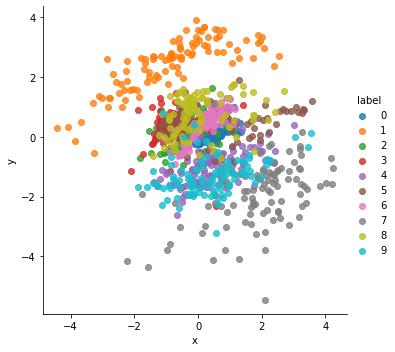

In [29]:
main()